## Spotify Classification Project
#### Calder Song

Part 0: Import data & deal with missing values

In [28]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
random.seed(42)

df0 = pd.read_csv("/Users/chaebeensong/Downloads/musicData.csv")
print(df0.columns)

#Dealing with question marks on the tempo column 
df0['tempo'] = df0['tempo'].replace('?', np.nan)
df0['tempo'] = pd.to_numeric(df0['tempo'])
mean_tempo = df0['tempo'].mean()
df0['tempo'] = df0['tempo'].fillna(mean_tempo)

#Checking if dropping other missing values is okay
missing_ratio = df0.isnull().mean()
high_missing = (missing_ratio > 0.01).any()
print("Any row has more than 1% missing values?", high_missing)

#drop other null values
df = df0.dropna()

Index(['instance_id', 'artist_name', 'track_name', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'obtained_date', 'valence', 'music_genre'],
      dtype='object')
Any row has more than 1% missing values? False


Part 1: Cleaning the data 

In [30]:
#1: Key (String variables to numbers)
note_to_num = {
    'C': 1,
    'D': 2,
    'E': 3,
    'F': 4,
    'G': 5,
    'A': 6,
    'B': 7
}

def convert_key(note):
    if pd.isnull(note):  
        return None
    base_note = note[0]
    sharp = 0.5 if '#' in note else 0
    return note_to_num.get(base_note, None) + sharp

df.loc[:, 'key_numeric'] = df['key'].apply(convert_key)

#2: Mode (Categorical values)

mode_to_num = {
    'Minor': 0,
    'Major': 1
}

df.loc[:, 'mode_numeric'] = df['mode'].map(mode_to_num)

#3: Mode (Categorical values)

genres_to_num = {
    'Alternative': 0,
    'Anime': 1,
    'Blues': 2,
    'Classical': 3,
    'Country': 4,
    'Electronic': 5,
    'Hip-Hop': 6,
    'Jazz': 7,
    'Rap': 8,
    'Rock':9
}

df.loc[:, 'genres_numeric'] = df['music_genre'].map(genres_to_num)

#4: Drop non-numeric or irrelvant variables

df = df.drop(columns=['key', 'mode', 'music_genre', 'obtained_date', 'instance_id', 'artist_name', 'track_name'])


/var/folders/lv/0206s7g121vg0y5mnzdq4f_00000gn/T/ipykernel_35674/695909789.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'key_numeric'] = df['key'].apply(convert_key)
/var/folders/lv/0206s7g121vg0y5mnzdq4f_00000gn/T/ipykernel_35674/695909789.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'mode_numeric'] = df['mode'].map(mode_to_num)
/var/folders/lv/0206s7g121vg0y5mnzdq4f_00000gn/T/ipykernel_35674/695909789.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy

Part 2: Dimensionality Reduction (PCA)

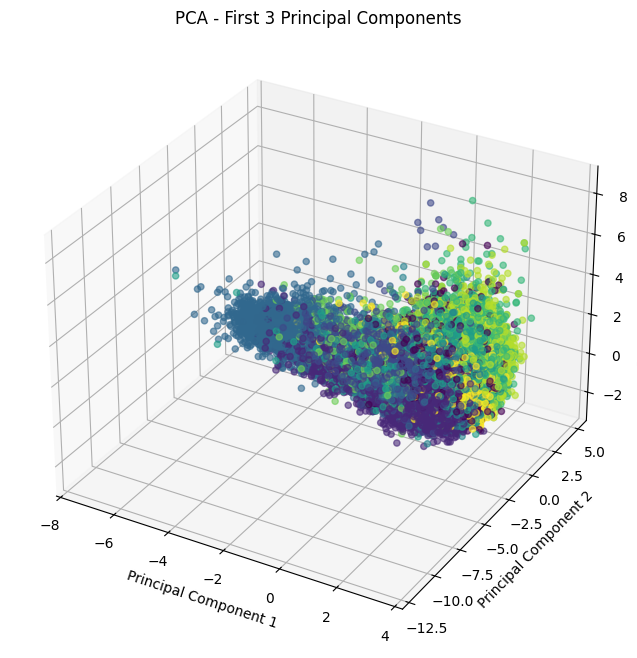

In [31]:
# Split dataset
train_data = []
test_data = []

for genre in df['genres_numeric'].unique():
    genre_data = df[df['genres_numeric'] == genre]
    test_samples = genre_data.sample(n=500, random_state=42)
    train_samples = genre_data.drop(test_samples.index)
    train_data.append(train_samples)
    test_data.append(test_samples)

train_data = pd.concat(train_data)
test_data = pd.concat(test_data)

X_train = train_data.drop(columns=['genres_numeric','mode_numeric', 'key_numeric'])  
Y_train = train_data['genres_numeric']

X_test = test_data.drop(columns=['genres_numeric','mode_numeric', 'key_numeric'])
Y_test = test_data['genres_numeric']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test) 

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)  
X_test_pca = pca.transform(X_test_scaled)  

X_cat_train = df.loc[X_train.index, ['mode_numeric', 'key_numeric']].values
X_cat_test = df.loc[X_test.index, ['mode_numeric', 'key_numeric']].values

# Combine PCA and categorical features
X_train_final = np.concatenate([X_train_pca, X_cat_train], axis=1)
X_test_final = np.concatenate([X_test_pca, X_cat_test], axis=1)


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_final[:, 0], X_train_final[:, 1], X_train_final[:, 2], c=Y_train, cmap='viridis', alpha=0.6)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA - First 3 Principal Components')
plt.savefig("images/pca_plot.png", dpi=300)
plt.show()

In [32]:
# Double check for NaNs
print(np.isnan(X_train_final).sum())
print(np.isnan(X_test_final).sum())  
print(np.isnan(Y_train).sum())
print(np.isnan(Y_test).sum())

0
0
0
0


Part 3: Clustering (GMM)

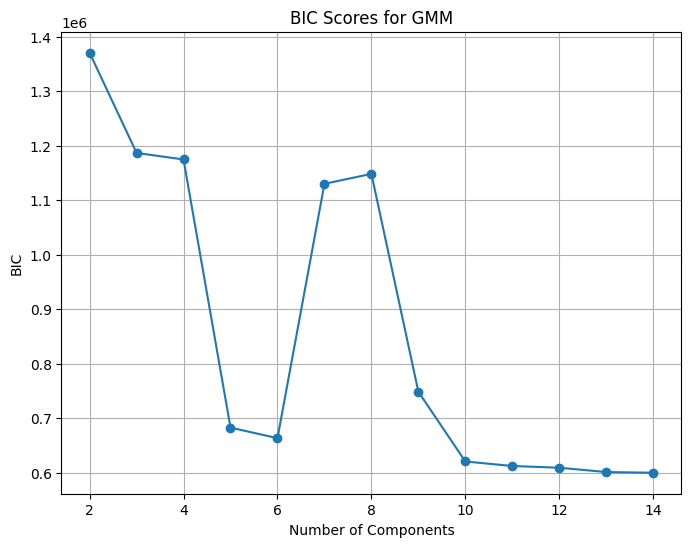

In [33]:
# Try different numbers of clusters
n_components_range = range(2, 15)
bics = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_train_final)
    bics.append(gmm.bic(X_train_final))

# Plot BIC values
plt.figure(figsize=(8,6))
plt.plot(n_components_range, bics, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC')
plt.title('BIC Scores for GMM')
plt.grid(True)
plt.savefig("images/bic_scores.png", dpi=300)
plt.show()

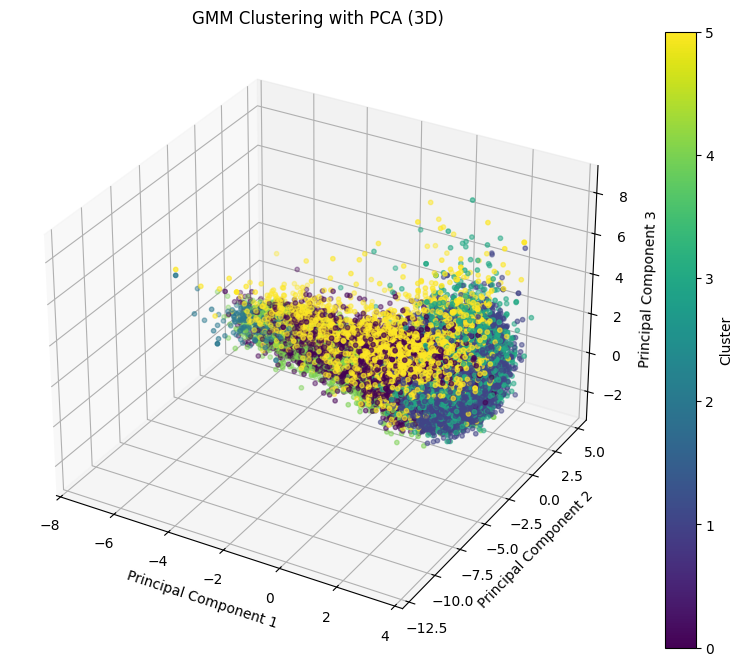

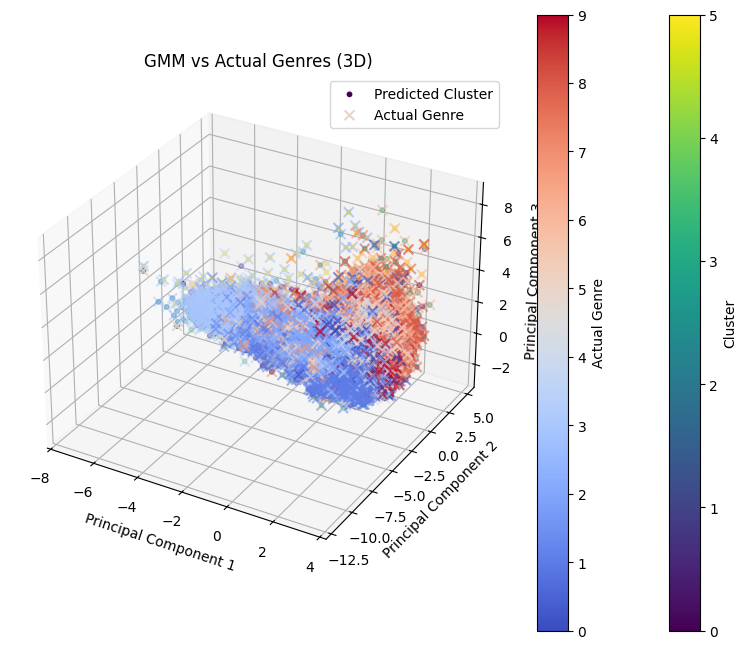

In [34]:
gmm_model = GaussianMixture(n_components= 6, random_state=42)
gmm_model.fit(X_train_final)

labels = gmm_model.predict(X_train_final)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_final[:, 0], X_train_final[:, 1], X_train_final[:, 2], c=labels, cmap='viridis', s=10)
ax.set_title('GMM Clustering with PCA (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
fig.colorbar(scatter, label='Cluster')  
plt.savefig("images/gmm_plot.png", dpi=300)
plt.show()


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_final[:, 0], X_train_final[:, 1], X_train_final[:, 2], c=labels, cmap='viridis', s=10, label='Predicted Cluster')
ax.scatter(X_train_final[:, 0], X_train_final[:, 1], X_train_final[:, 2], c=Y_train, cmap='coolwarm', marker='x', s=50, label='Actual Genre')
ax.set_title('GMM vs Actual Genres (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
fig.colorbar(ax.collections[0], ax=ax, label='Cluster')  # Color bar for clusters
fig.colorbar(ax.collections[1], ax=ax, label='Actual Genre')  # Color bar for actual genres
ax.legend()
plt.show()

Part 4: Classification (Neural Network)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4138 - loss: 1.6426 - val_accuracy: 0.5440 - val_loss: 1.1918
Epoch 2/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5071 - loss: 1.2986 - val_accuracy: 0.5562 - val_loss: 1.1588
Epoch 3/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5254 - loss: 1.2531 - val_accuracy: 0.5602 - val_loss: 1.1505
Epoch 4/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5322 - loss: 1.2290 - val_accuracy: 0.5712 - val_loss: 1.1278
Epoch 5/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5389 - loss: 1.2115 - val_accuracy: 0.5714 - val_loss: 1.1055
Epoch 6/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5425 - loss: 1.1946 - val_accuracy: 0.5822 - val_loss: 1.0951
Epoch 7/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5482 - loss: 1.1786 - val_accuracy: 0.5788 - val_loss: 1.0948
Epoch 8/50
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5460 - loss: 1.1810 - val_accurac

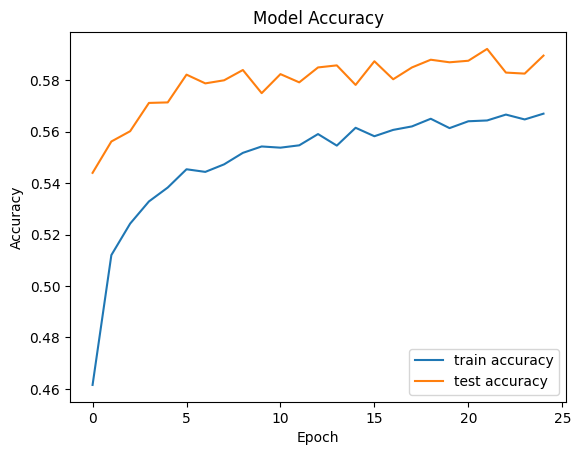

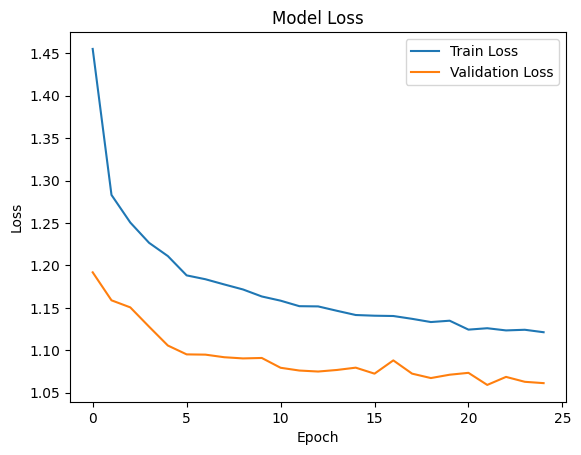

In [35]:
# Initialize the neural network model
model = Sequential()

model.add(Dense(256, input_dim=X_train_final.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, input_dim=X_train_final.shape[1], activation='relu'))  
model.add(BatchNormalization())
model.add(Dropout(0.2))  # Dropout layer with 20% dropout
model.add(Dense(64, activation='relu'))  
model.add(BatchNormalization())
model.add(Dropout(0.2))  # Another dropout layer
model.add(Dense(10, activation='softmax'))  # Output layer for 10 classes (genres), using softmax for multi-class classification

model.compile(loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification
              optimizer='adam',  
              metrics=['accuracy'])  # Evaluation metric

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_final, Y_train, epochs=50, batch_size=32, validation_data=(X_test_final, Y_test), callbacks=[early_stopping])

# Plot accuracy 
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step


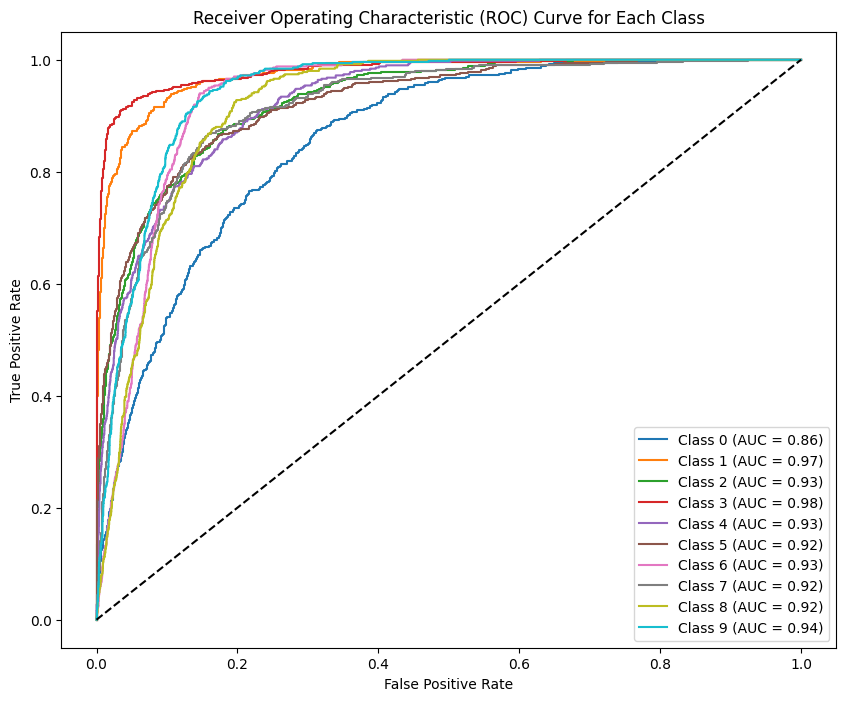

In [36]:
predictions = model.predict(X_test_final)

predicted_labels = predictions.argmax(axis=1)

# Compute AUC
roc_auc = {}
for i in range(10):  # 10 genres/classes
    fpr, tpr, _ = roc_curve(Y_test == i, predictions[:, i])
    roc_auc[i] = auc(fpr, tpr)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(10):
    fpr, tpr, _ = roc_curve(Y_test == i, predictions[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random model)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc='lower right')
plt.savefig("images/roc_curve.png", dpi=300)
plt.show()